# The following is used to test new features with the assigned cost function.

In [1]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
import time

In [2]:

control_space_size = 3 

U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size)) 
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size)) 
time_step = 0.033 

In [3]:

def model_step(x,velocities,time_step):
    """_summary_

    Args:
        x (float): posizione attuale del robot
        velocities (float): velocità del robot
        time_step (_type_): intervallo di tempo per eseguire uno step del modello
    """
    poses = np.zeros((2,1))
    
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    return(poses)



def my_logpdf(x, u, covar): 
    """_summary_

    Args:
        x (float): punto di valutazione della pdf
        u (float): valore medio della pdf
        covar (float): matrice di covarianza della pdf

    Returns:
        float: pdf ottenuta dai dati campionata
    """
 
    k = len(x) 
    
    a = np.transpose(x - u) 
    
    b = np.linalg.inv(covar) 
   
    c = x - u 
   
    d = np.matmul(a, b) 
    
    e = np.matmul(d, c)
   
    numer = np.exp(-0.5 * e)
   
    f = (2 * np.pi)**k 
    g = np.linalg.det(covar) 
   
    denom = np.sqrt(f * g) 
    
    pdf = numer / denom 

    return pdf 





# WP0

In [4]:
##### WP0: formalize the control problem #####


In [5]:
def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar) 
 
    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi))) 


    return(cost)

# WP1

In [6]:
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):

        
        target_pf = 1/control_space_size**2 
        time_step = 0.033 

        pf = np.zeros((control_space_size,control_space_size)) 
        for i in range(control_space_size):
            for j in range(control_space_size):
              
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step) 
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]]) 
                f = st.multivariate_normal(next_state.reshape((2,)),cov)  
                N_samples = 20 
                next_sample = f.rvs(N_samples) 

                cost=0 
                for k in range(N_samples):
                    
                    cost+=state_cost(next_sample[k,:],goal_points,obs_points)/N_samples  

                log_DKL = np.exp(-(-f.entropy())-cost)
                pf[i,j] = log_DKL 
                
        S2 = np.sum(pf)  
        
        pf = np.divide(pf,S2) 

        flat = pf.flatten()
        sample_index = np.random.choice(a=flat.size, p=flat)

        adjusted_index = np.unravel_index(sample_index, pf.shape)

        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

In [7]:
goal_points = np.array(np.mat('-1.4; -0.8; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) 

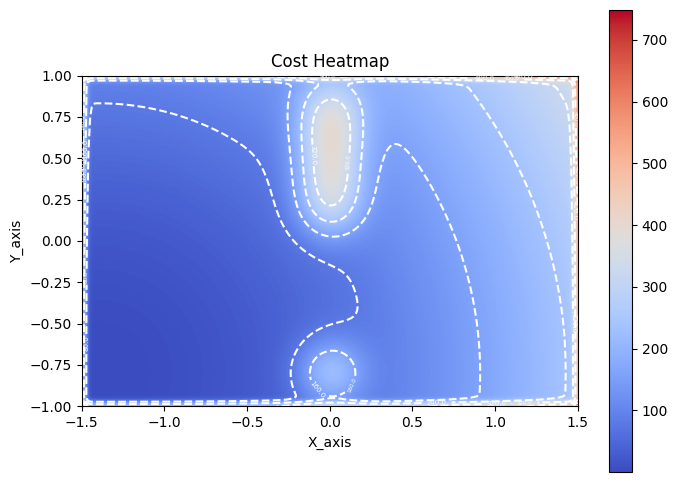

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cost_matrix = np.zeros((300, 200))
X = np.linspace(-1.5, 1.5, 300)
Y = np.linspace(-1, 1, 200)

for i in range(200):
    for j in range(300):
        state = [X[j], Y[i]]
        cost_matrix[j, i] = state_cost(state, goal_points, obs_points)

Cost_Map = pd.DataFrame(cost_matrix, index=list(X), columns=Y)

data_rotated = np.transpose(Cost_Map)

plt.figure(figsize=(8, 6))

plt.imshow(data_rotated, extent=[X.min(), X.max(), Y.min(), Y.max()],
           origin='lower', cmap='coolwarm')
plt.colorbar()

contours = plt.contour(X, Y, data_rotated, levels=10, colors='white', linestyles='dashed')

plt.clabel(contours, inline=True, fontsize=4, fmt='%1.1f')

plt.clabel(contours, inline=True, fontsize=5, fmt='%1.1f')

plt.xlabel('X_axis')
plt.ylabel('Y_axis')
plt.title('Cost Heatmap')

plt.show()


# WP2

In [9]:
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] 

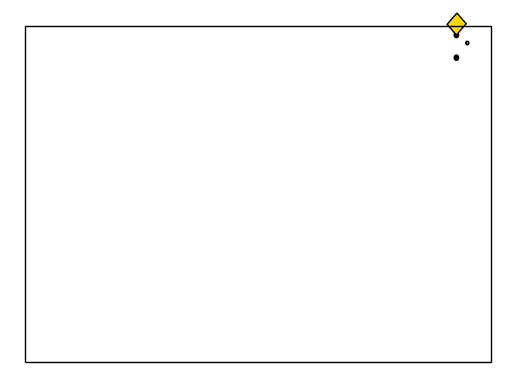

##### DEBUG OUTPUT #####
Your simulation will take approximately 37 real seconds when deployed on the Robotarium. 

	 Simulation had 991 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

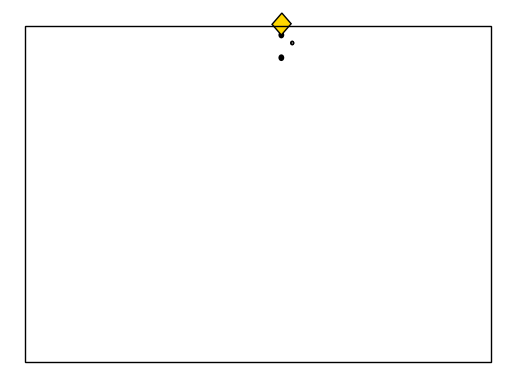

##### DEBUG OUTPUT #####
Your simulation will take approximately 37 real seconds when deployed on the Robotarium. 

	 Simulation had 1974 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

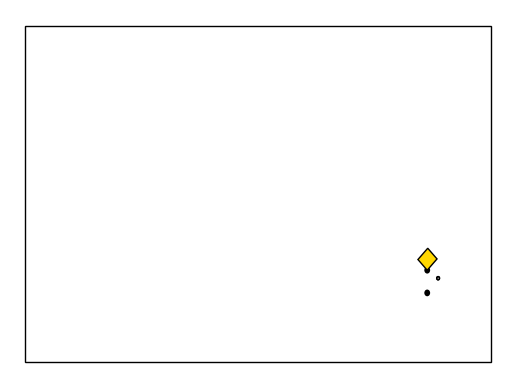

##### DEBUG OUTPUT #####
Your simulation will take approximately 38 real seconds when deployed on the Robotarium. 

	 Simulation had 2980 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

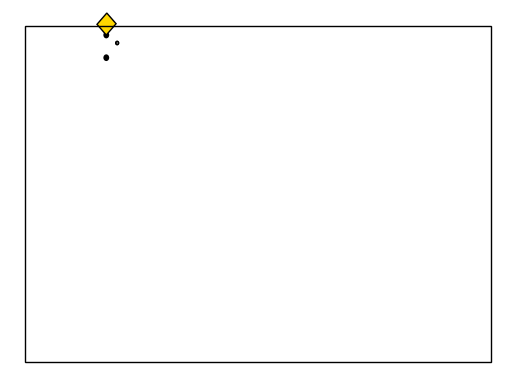

##### DEBUG OUTPUT #####
Your simulation will take approximately 24 real seconds when deployed on the Robotarium. 

	 Simulation had 3584 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

In [10]:
N = 1 

N_experiment = 4

X_Si = [0]*N_experiment

D_Xi = [0]*N_experiment

for I in range(N_experiment):

    X_si = []
    D_xi = []

    
    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)


    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() 
    _, uni_to_si_states = create_si_to_uni_mapping()
    
    x = r.get_poses()
    x_si = uni_to_si_states(x)

    CM = np.random.rand(N+10,3) 
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()
    
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

        x = r.get_poses()
        
        x_si = uni_to_si_states(x)

        
        X_si.append(x_si) 


        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]]) 

        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov) 
        x_sample = x_pdf.rvs() 


        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])


        dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points)

        D_xi.append(dxi)
        
        dxu = si_to_uni_dyn(dxi, x)


        r.set_velocities(np.arange(N), dxu)
        r.step()

    D_Xi[I] = D_xi

    X_Si[I] = X_si

    
    r.call_at_scripts_end()

In [11]:
XX = X_Si
UU = D_Xi

In [12]:

X = []      
X_plot = [] 
U = []     
U_plot = [] 


for i in range(len(XX)):
    X.append(np.array(XX[i]))     
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []

for i in range(len(UU)):
    U.append(np.array(UU[i]))       
    U_plot.append(np.array(UU[i]))  

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))


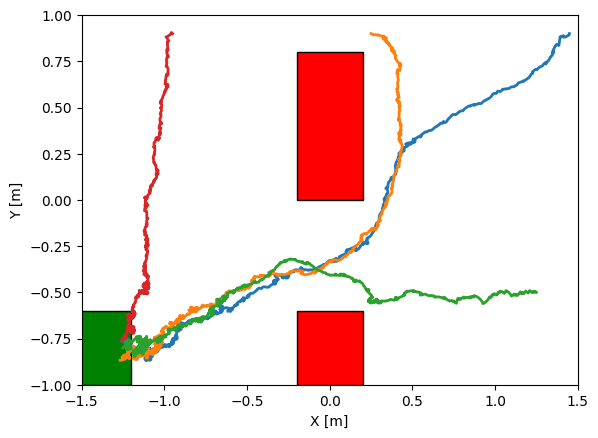

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np


plt.plot(X_plot[0][:, 0], X_plot[0][:, 1], linewidth=2)
plt.plot(X_plot[1][:, 0], X_plot[1][:, 1], linewidth=2)
plt.plot(X_plot[2][:, 0], X_plot[2][:, 1], linewidth=2)
plt.plot(X_plot[3][:, 0], X_plot[3][:, 1], linewidth=2)


square1 = plt.Rectangle((-1.6, -1), 0.4, 0.4, fc='green', ec="black")
square3 = plt.Rectangle((-0.2, -1), 0.4, 0.4, fc='red', ec="black")
square2 = plt.Rectangle((-0.2, 0), 0.4, 0.8, fc='red', ec="black")


plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)

plt.ylim(-1, 1)
plt.xlim(-1.5, 1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')



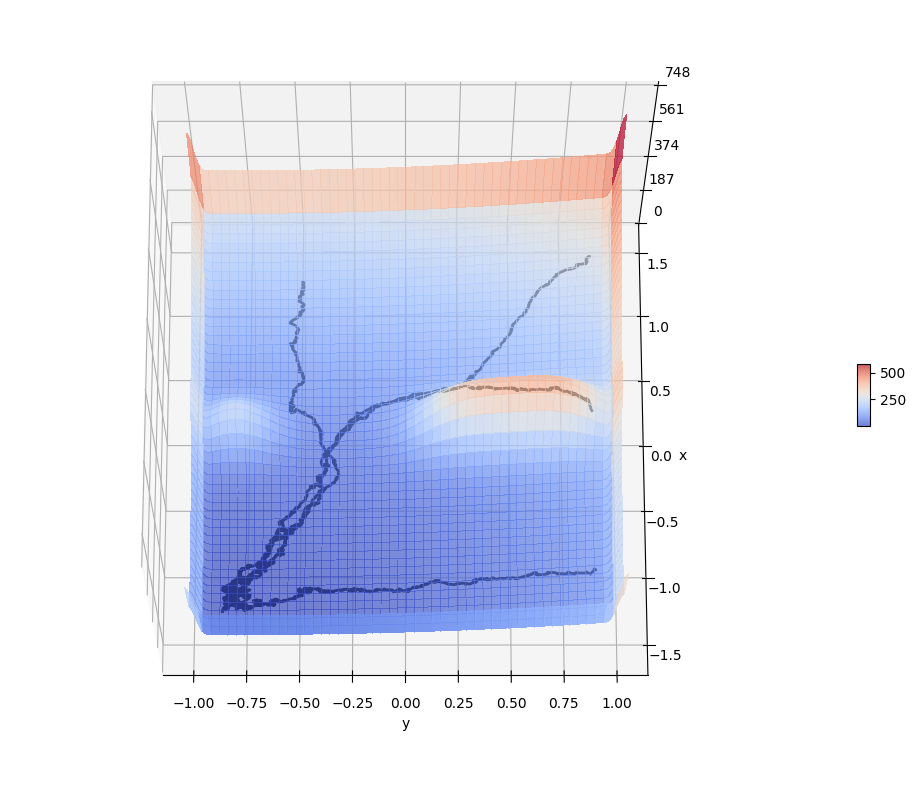

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np



fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

X_axis = np.linspace(-1.5, 1.5, 300)
Y_axis = np.linspace(-1, 1, 200)
X_surface, Y_surface = np.meshgrid(Y_axis, X_axis)

surf = ax.plot_surface(X_surface, Y_surface, Cost_Map, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7)

for i in range(len(X_plot)):
    Z_surface = np.zeros_like(X_plot[i][:, 0])  
    ax.plot(X_plot[i][:, 1], X_plot[i][:, 0], Z_surface, linewidth=2, color='black')

ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter('{x:.0f}')
ax.set_xlabel('y')
ax.set_ylabel('x')

ax.view_init(elev=70, azim=-90)  

fig.colorbar(surf, shrink=0.08, aspect=5)

plt.show()


2023-12-22 20:56:35.325 Python[9839:389169] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


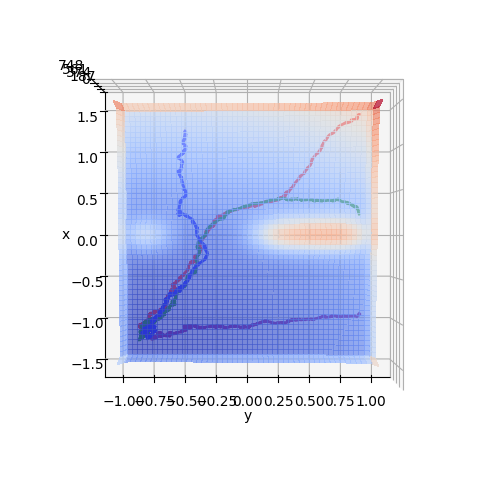

In [15]:
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

trajectory_colors = ['red', 'green', 'blue', 'purple']  
def update_plot(*args):
    show_surface = show_surface_var.get()
    selected_trajectories = [trajectory_vars[i].get() for i in range(len(X_plot))]

    ax.clear()

    if show_surface:
        surf = ax.plot_surface(X_surface, Y_surface, Cost_Map, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7)

    for i, (checkbox_state, color) in enumerate(zip(selected_trajectories, trajectory_colors)):
        if checkbox_state:
            Z = np.zeros_like(X_plot[i][:, 0])  
            ax.plot(X_plot[i][:, 1], X_plot[i][:, 0], Z, linewidth=2, color=color)

    ax.zaxis.set_major_locator(LinearLocator(5))
    ax.zaxis.set_major_formatter('{x:.0f}')
    ax.set_xlabel('y')
    ax.set_ylabel('x')

    ax.view_init(elev=90, azim=-90)

    canvas.draw()

root = tk.Tk()
root.title("Trajectory Viewer")

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.draw()
canvas.get_tk_widget().pack(side='top', fill='both', expand=1)

style = ttk.Style()
style.configure("TRound.TCheckbutton", relief="flat", roundness=5, anchor="w") 

show_surface_var = tk.BooleanVar()
show_surface_var.set(True)
show_surface_var.trace_add("write", update_plot)  
show_surface_checkbox = ttk.Checkbutton(root, text="Show Surface", variable=show_surface_var, style="TRound.TCheckbutton")
show_surface_checkbox.pack(padx=10, pady=(10, 5), anchor="w")  

trajectory_vars = [tk.BooleanVar() for _ in range(len(X_plot))]
for i, trajectory_var in enumerate(trajectory_vars):
    trajectory_var.trace_add("write", update_plot)   
    checkbox = ttk.Checkbutton(root, text=f"Trajectory {i+1}", variable=trajectory_var, style="TRound.TCheckbutton")
    checkbox.pack(padx=10, pady=(0, 5), anchor="w")  

update_plot()

root.mainloop()


# WP3

In [16]:
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

In [17]:

N_feature = np.size(obs_points_f,axis=1)+2 

def feature(next_state,goal_points,obs_points,N_feature): 

    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v) 
    features = np.zeros(N_feature) 
    
    for i in range(np.size(obs_points,axis=1)): 
        features[i+2] = my_logpdf(next_state[:2],obs_points[:2,i],covar) 

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) 
    
    features[1] = np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
    + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
    + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
    

 
    return features 

In [18]:
%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time

M = np.size(X,axis=0) - 1

w = cp.Variable((1,N_feature)) 

constraints = [w >= 0]

R = np.zeros((99,1))
L = []

f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))

for i in range(M):

    features = np.zeros((N_feature,control_space_size,control_space_size))
   
    state = np.array(X[i,:]) 
    x0 = state.reshape(-1,1)

    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) 
    
    for j in range(control_space_size):
        for k in range(control_space_size):
            
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)

            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])

            f = st.multivariate_normal(next_state.reshape((2,)),cov) 
            next_sample = f.mean

            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))

          
            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            
            log_DKL = np.exp(-(-f.entropy()))
            pf[j,k] = log_DKL
    PF[:,:,i] = pf
   
    features = np.reshape(features,(N_feature,control_space_size**2))

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)
    

    l = -(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w @ features,(control_space_size,control_space_size)) + cp.log(PF[:,:,i]))
 
    L.append(l) 
objective = cp.Minimize(cp.sum(L))

prob = cp.Problem(objective)

result = prob.solve(verbose = False)


print("status:", prob.status)
print("optimal value", prob.value)

In [19]:
weights = w.value
print('weights:',weights)

weights: [[-1.17429649e+01  9.69509721e-29 -6.42444723e+00 -8.74508078e-02
  -8.22717877e-01 -1.78663764e+01 -7.74630578e+00 -1.22046485e-01
   9.91594796e-01 -8.54485259e-01 -2.72609526e-01  4.09986318e-01
  -1.93011027e-01 -1.04166608e-02 -8.74573377e-02  1.45681326e-01
   1.59148674e-01]]


In [20]:


import numpy as np  
import scipy.stats as st 
import pandas as pd  

goal_points = np.array(np.mat('-1.4; -0.8; 0'))  


obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) 

def state_cost(state, goal_points, obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)  
    covar = np.diag(v)  
    gauss_sum = 0  

    for i in range(np.size(obs_points, axis=1)):  
        gauss_sum += 20 * my_logpdf(state[:2], obs_points[:2, i], covar) 

    cost = 30 * ((state[0] - goal_points[0]) ** 2 + (state[1] - goal_points[1]) ** 2) + gauss_sum 
    return cost

Cost_Map = np.zeros((300, 200)) 
X_axis = np.linspace(-1.5, 1.5, 300)  
Y_axis = np.linspace(-1, 1, 200)  

for i in range(200):
    for j in range(300):
        state = np.array([X_axis[j], Y_axis[i]])  
        Cost_Map[j, i] = state_cost(state, goal_points, obs_points)  

Coat_Map = pd.DataFrame(Cost_Map, index=list(X_axis), columns=Y_axis) 


In [21]:


import numpy as np  
import scipy.stats as st  

goal_points = np.array(np.mat('-1.4; -0.8; 0')) 
def state_cost_estimated(state, goal_points, obs_points, weights):
    v = np.array([0.025, 0.025], dtype=np.float32)  
    covar = np.diag(v)  

    gauss_sum = 0  

    for i in range(np.size(obs_points, axis=1)): 
        gauss_sum += -weights[:, i + 2] * my_logpdf(state[:2], obs_points[:2, i], covar)  

    cost = -weights[:, 0] * (((state[0] - goal_points[0]) ** 2 + (state[1] - goal_points[1]) ** 2)) + gauss_sum - weights[:, 1] * (np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
    + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
    + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    
    return cost

Cost_Map = np.zeros((300, 200)) 
X_axis = np.linspace(-1.5, 1.5, 300)  
Y_axis = np.linspace(-1, 1, 200)  

for i in range(200):
    for j in range(300):
        state = np.array([X_axis[j], Y_axis[i]])  
        Cost_Map[j, i] = state_cost_estimated(state, goal_points, obs_points_f, weights)  

/var/folders/h8/_fxskz7s2_j0ywzp2t4cqg900000gn/T/ipykernel_9839/4075193831.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels)
/var/folders/h8/_fxskz7s2_j0ywzp2t4cqg900000gn/T/ipykernel_9839/4075193831.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


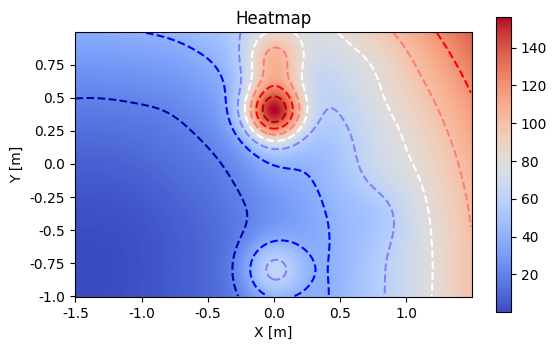

<Figure size 640x480 with 0 Axes>

In [22]:
import numpy as np
import matplotlib.pyplot as plt


data_rotated = np.transpose(Cost_Map)


fig, ax = plt.subplots()


heatmap = ax.imshow(data_rotated,cmap='coolwarm')

contours = ax.contour(data_rotated,cmap='seismic' , linestyles='dashed')


cbar = plt.colorbar(heatmap,shrink=0.8)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Heatmap')

ax.invert_yaxis()


x_ticklabels = np.arange(-2, 2, 0.5) 
y_ticklabels = np.arange(-1.25, 1.25, 0.25)  

ax.set_xticklabels(x_ticklabels)
ax.set_yticklabels(y_ticklabels)

 
plt.show()

<Figure size 2000x1000 with 0 Axes>

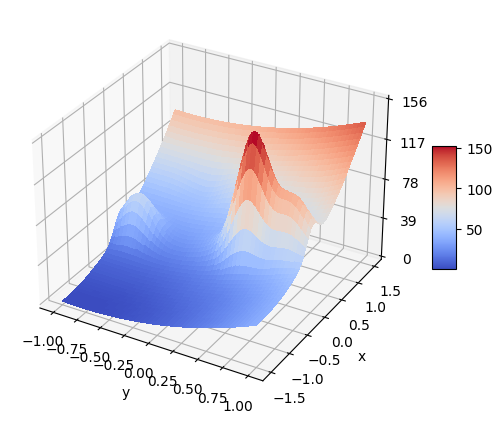

In [23]:
import matplotlib.pyplot as plt  
from matplotlib import cm 
from matplotlib.ticker import LinearLocator 
import numpy as np  

fig = plt.figure(figsize=(20, 10))  
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})  
fig.figure.set_figheight(20)  

X_axis = np.linspace(-1.5, 1.5, 300) 
Y_axis = np.linspace(-1, 1, 200)  
X, Y = np.meshgrid(Y_axis, X_axis)  

surf = ax.plot_surface(X, Y, Cost_Map, cmap=cm.coolwarm, linewidth=0, antialiased=False)


ax.zaxis.set_major_locator(LinearLocator(5))  
ax.zaxis.set_major_formatter('{x:.0f}')  

ax.set_xlabel('y')  
ax.set_ylabel('x')  



fig.colorbar(surf, shrink=0.08, aspect=5)

plt.show() 

In [24]:
def Control_step(state, U_space_1, U_space_2, goal_points, obs_points, weights):
    target_pf = 1 / control_space_size**2  
    time_step = 0.033  

    pf = np.zeros((control_space_size, control_space_size)) 

    for i in range(control_space_size):
        for j in range(control_space_size):
            
            next_state = model_step(state, [U_space_1[i], U_space_2[j]], time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])  
            f = st.multivariate_normal(next_state.reshape((2,)), cov)  

            N_samples = 20  
            next_sample = f.rvs(N_samples)  

            cost = 0  

       
            for k in range(N_samples):
                cost += state_cost_estimated(next_sample[k, :], goal_points, obs_points, weights) / N_samples

          
            log_DKL = np.exp(-(-f.entropy()) - cost)
            pf[i, j] = log_DKL  

    S2 = np.sum(pf) 
    pf = np.divide(pf, S2)  

    flat = pf.flatten() 
    sample_index = np.random.choice(a=flat.size, p=flat)  

    adjusted_index = np.unravel_index(sample_index, pf.shape)  
    action = np.reshape(np.array([U_space_1[adjusted_index[0]], U_space_2[adjusted_index[1]]]), (2, 1))

    return action  


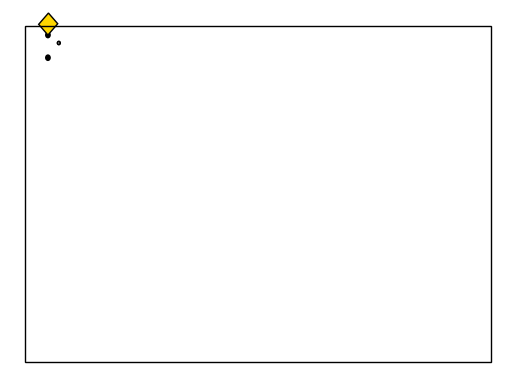

##### DEBUG OUTPUT #####
Your simulation will take approximately 59 real seconds when deployed on the Robotarium. 

	 Simulation had 5094 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

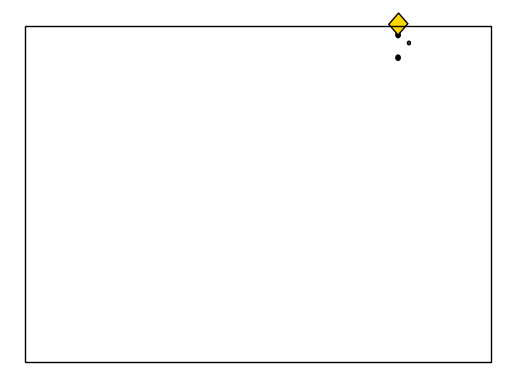

##### DEBUG OUTPUT #####
Your simulation will take approximately 94 real seconds when deployed on the Robotarium. 

	 Simulation had 7553 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

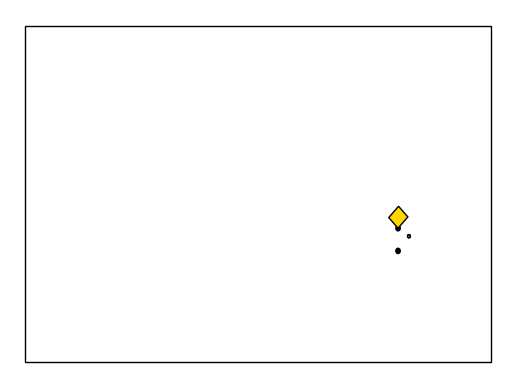

##### DEBUG OUTPUT #####
Your simulation will take approximately 142 real seconds when deployed on the Robotarium. 

	 Simulation had 11249 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

In [25]:

N = 1
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]
N_experiment = 3

X_Si = [0]*N_experiment
D_Xi = [0]*N_experiment

for I in range(N_experiment):

    X_si = []
    D_xi = []

    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion()

    x = r.get_poses()
    x_si = uni_to_si_states(x)

    CM = np.random.rand(N+10,3) 
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()
   
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

        x = r.get_poses()
        x_si = uni_to_si_states(x)

      
        X_si.append(x_si)


        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs() 
        
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

       
        dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points,weights)

        D_xi.append(dxi)

        dxu = si_to_uni_dyn(dxi, x)

       
        r.set_velocities(np.arange(N), dxu)
     
        r.step()
      

    D_Xi[I] = D_xi
    X_Si[I] = X_si

    r.call_at_scripts_end()

In [26]:
XX = X_Si
UU = D_Xi

In [27]:
X = []
X_plot = []
U = []
U_plot = []


for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

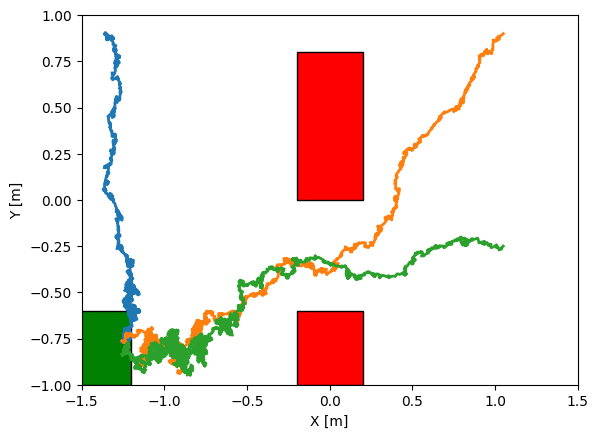

In [28]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

plt.plot(X_plot[0][:,0],X_plot[0][:,1],linewidth=2)
plt.plot(X_plot[1][:,0],X_plot[1][:,1],linewidth=2)
plt.plot(X_plot[2][:,0],X_plot[2][:,1],linewidth=2)



square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square3 = plt.Rectangle((-0.2,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 0.8, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

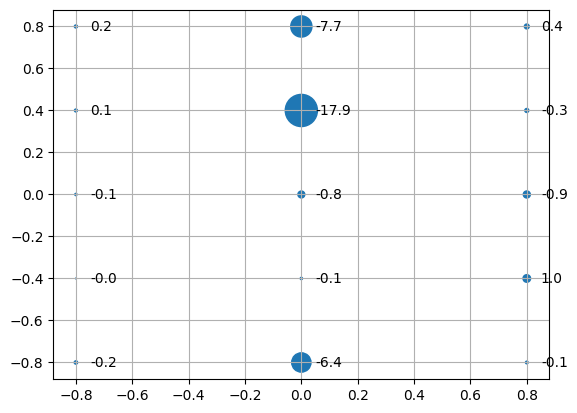

In [29]:

import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots()


circle_sizes = np.abs(weights[:, 2:]) * 30
ax.scatter(obs_points_f[0, :], obs_points_f[1, :], circle_sizes)

w = np.zeros((15,))

for j in range(15):
    wt = float(weights[:, j + 2])
    w[j] = round(wt, 1)

for i, txt in enumerate(w.reshape(15,)):
    ax.annotate(txt, (obs_points_f[0, i] + 0.05, obs_points_f[1, i]), ha='left', va='center')

plt.grid(True)
plt.show()
